In [1]:
# notebook used to make some methods figures, not to generate data for downstream analysis

from neuron import h
from neuron.units import mV, ms
h.load_file('stdrun.hoc')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math

In [2]:
def gen_histories(sim_length = 5000, stim_interval = 10, num_histories = 100):

    # Set up biophysical model
    axon = h.Section(name='axon')
    axon.insert(h.hh)

    # add a synapse
    syn = h.ExpSyn(axon(0))
    syn.tau = 1 * ms
    syn.e = 0 * mV
    syn_current = h.Vector().record(syn._ref_i)

    # add a stimulus
    stim = h.NetStim()
    stim.number = 9999999
    stim.interval = stim_interval * ms
    stim.noise = True
    stim.start = 0 * ms

    stim_times = h.Vector()

    # connect stimulus to synapse
    nc = h.NetCon(stim, syn)
    nc.delay = 0 * ms
    nc.weight[0] = 0.2
    nc.record(stim_times)

    # setup recording
    _t = h.Vector().record(h._ref_t)
    _v = h.Vector().record(axon(0.5)._ref_v)
    _m = h.Vector().record(axon(0.5).hh._ref_m)
    _n = h.Vector().record(axon(0.5).hh._ref_n)
    _h = h.Vector().record(axon(0.5).hh._ref_h)
    spike_times = h.Vector()
    nc_self = h.NetCon(axon(0.5)._ref_v, None, sec=axon)
    nc_self.record(spike_times)

    # run simulation
    h.finitialize(-65 * mV)
    h.continuerun(sim_length * ms)
    
    histories = np.array((_v, _m, _h, _n))[:, random.sample(range(0, len(_v)), num_histories)]

    return histories, np.array((_t, _v, _m, _h, _n, syn_current)), list(spike_times), list(stim_times)

histories, sim_df, spike_times, stim_times = gen_histories(num_histories = 1000)
print('number of histories:', histories.shape[1])

number of histories: 1000


In [3]:
'''with open('./data/stim_times.txt', 'w') as f:
    for item in stim_times:
        f.write("%s\n" % item)'''

'with open(\'./data/stim_times.txt\', \'w\') as f:\n    for item in stim_times:\n        f.write("%s\n" % item)'

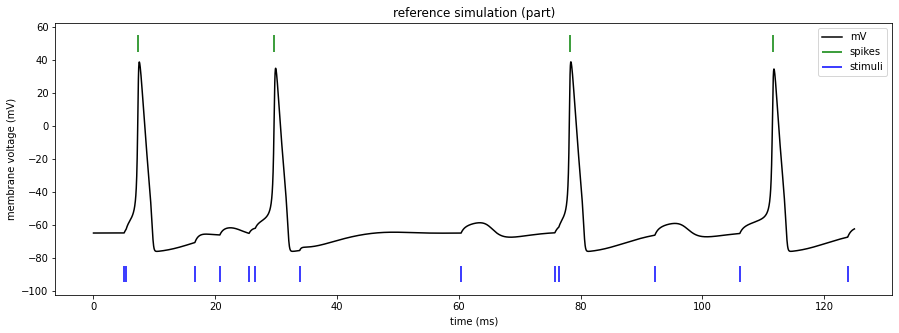

In [4]:
# part
n_frames = 5000

plt.subplots(figsize=(15,5))
plt.plot(np.arange(0, (1/40)*n_frames, (1/40)), sim_df[1,0:n_frames], color='black')
plt.vlines([st for st in spike_times if st < (1/40)*n_frames], 45, 55, color='green')
plt.vlines([st for st in stim_times if st < (1/40)*n_frames], -95, -85, color='blue')
plt.legend(['mV','spikes','stimuli'], loc = 'upper right')
plt.title('reference simulation (part)')
plt.ylabel('membrane voltage (mV)')
plt.xlabel('time (ms)')
plt.show()

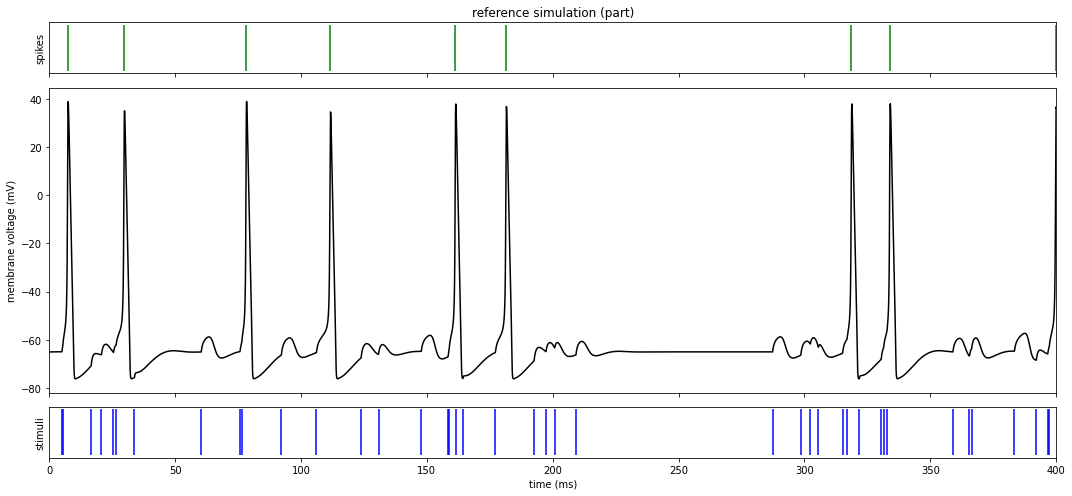

In [5]:
# part
n_frames = 50000

fig, axes = plt.subplots(3,1, figsize=(15,7), gridspec_kw={'height_ratios': [1, 6, 1]}, 
                         tight_layout = True, sharex = True)

axes[0].set_title('reference simulation (part)')

axes[1].plot(np.arange(0, (1/40)*n_frames, (1/40)), sim_df[1,0:n_frames], color='black')
axes[1].set_ylabel('membrane voltage (mV)')

axes[0].vlines([st for st in spike_times if st < (1/40)*n_frames], 45, 55, color='green')
axes[0].set_ylabel('spikes')
axes[0].set_yticks([])
axes[0].set_xlim(0, 400)

axes[2].vlines([st for st in stim_times if st < (1/40)*n_frames], -95, -85, color='blue')
axes[2].set_ylabel('stimuli')
axes[2].set_yticks([])

#plt.legend(['mV','spikes','stimuli'], loc = 'upper right')

plt.xlabel('time (ms)')
plt.show()

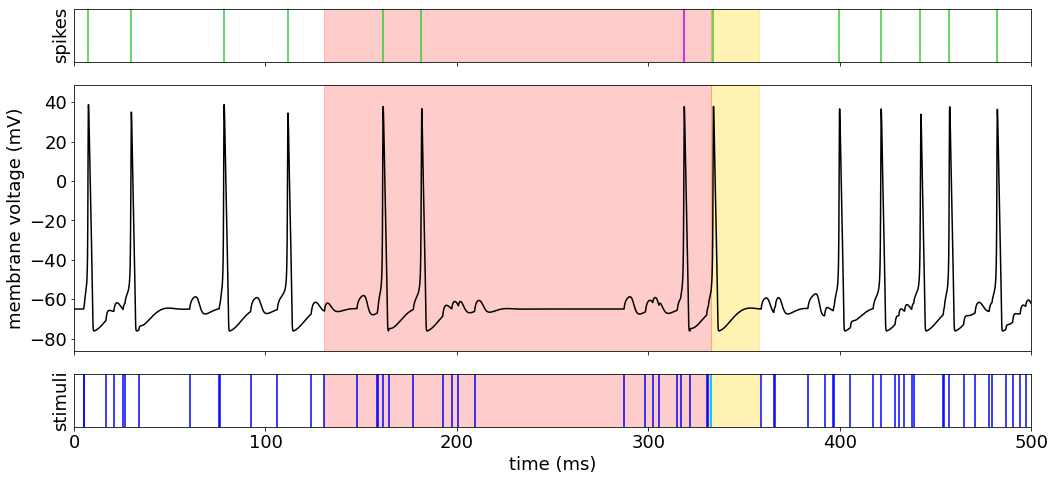

In [6]:
# sampled reference simulation figure
n_frames = 50000
end_time = 500

plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(3,1, figsize=(15,7), gridspec_kw={'height_ratios': [1, 5, 1]}, 
                         tight_layout = True, sharex = True)
# title
#axes[0].set_title('reference simulation (part)')

# membrane voltage
axes[1].plot(np.arange(0, (1/40)*n_frames, (1/40)), sim_df[1,0:n_frames], color='black')
axes[1].set_ylim(min(sim_df[1,0:n_frames]) - 10, max(sim_df[1,0:n_frames]) + 10)
axes[1].set_ylabel('membrane voltage (mV)')

# output
axes[0].vlines([st for st in spike_times if st < (1/40)*n_frames], 0, 100, color='limegreen')
axes[0].set_ylabel('spikes')
axes[0].set_yticks([])
axes[0].set_xlim(0, end_time)
axes[0].set_ylim(0,1)

# sampled spike
spike_ind = 6
axes[0].vlines([st for st in spike_times if st < (1/40)*n_frames][spike_ind], 0, 100, color='magenta')

# stimuli
axes[2].vlines([st for st in stim_times if st < (1/40)*n_frames], 0, 100, color='blue')
axes[2].set_ylabel('stimuli')
axes[2].set_yticks([])
axes[2].set_ylim(0,1)

# pivot stimulus
pivot_ind = 33
axes[2].vlines([st for st in stim_times if st < (1/40)*n_frames][pivot_ind], 0, 100, color='cyan')

# post spike windows
start = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind]
length = 25
axes[0].add_patch(plt.Rectangle((start,0), length, 100, color = 'gold', alpha = 0.3))
axes[1].add_patch(plt.Rectangle((start,-1000), length, 10000, color = 'gold', alpha = 0.3))
axes[2].add_patch(plt.Rectangle((start,0), length, 100, color = 'gold', alpha = 0.3))

# preceding stimuli windows
start = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind - 20]
length = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind] - start
axes[0].add_patch(plt.Rectangle((start,0), length, 100, color = 'red', alpha = 0.2))
axes[1].add_patch(plt.Rectangle((start,-1000), length, 10000, color = 'red', alpha = 0.2))
axes[2].add_patch(plt.Rectangle((start,0), length, 100, color = 'red', alpha = 0.2))

plt.xlabel('time (ms)')
plt.show()

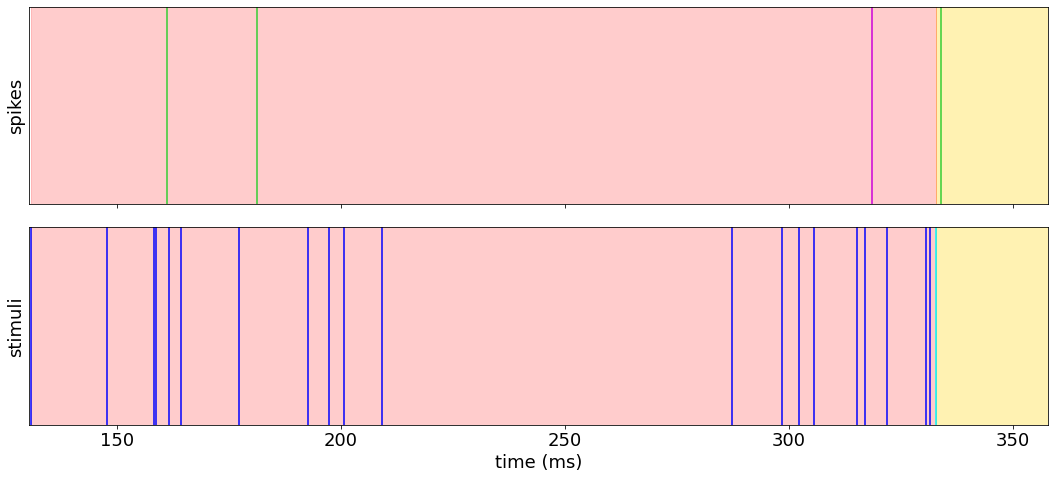

In [7]:
# sampled reference simulation figure zoom
# sampled reference simulation figure
n_frames = 50000
start_time = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind - 20] - .3 
end_time = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind] + 25

plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(2,1, figsize=(15,7), gridspec_kw={'height_ratios': [1, 1]}, 
                         tight_layout = True, sharex = True)

# output
axes[0].vlines([st for st in spike_times if st < (1/40)*n_frames], 0, 100, color='limegreen')
axes[0].set_ylabel('spikes')
axes[0].set_yticks([])
axes[0].set_xlim(start_time, end_time)
axes[0].set_ylim(0,1)

# sampled spike
axes[0].vlines([st for st in spike_times if st < (1/40)*n_frames][spike_ind], 0, 100, color='magenta')

# stimuli
axes[1].vlines([st for st in stim_times if st < (1/40)*n_frames][0:pivot_ind], 0, 100, color='blue')
axes[1].set_ylabel('stimuli')
axes[1].set_yticks([])
axes[1].set_ylim(0,1)

# pivot stimulus
axes[1].vlines([st for st in stim_times if st < (1/40)*n_frames][pivot_ind], 0, 100, color='cyan')

# post spike windows
start = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind]
length = 25
axes[0].add_patch(plt.Rectangle((start,0), length, 100, color = 'gold', alpha = 0.3))
axes[1].add_patch(plt.Rectangle((start,0), length, 100, color = 'gold', alpha = 0.3))

# preceding stimuli windows
start = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind - 20]
length = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind] - start
axes[0].add_patch(plt.Rectangle((start,0), length, 100, color = 'red', alpha = 0.2))
axes[1].add_patch(plt.Rectangle((start,0), length, 100, color = 'red', alpha = 0.2))

plt.xlabel('time (ms)')
plt.show()

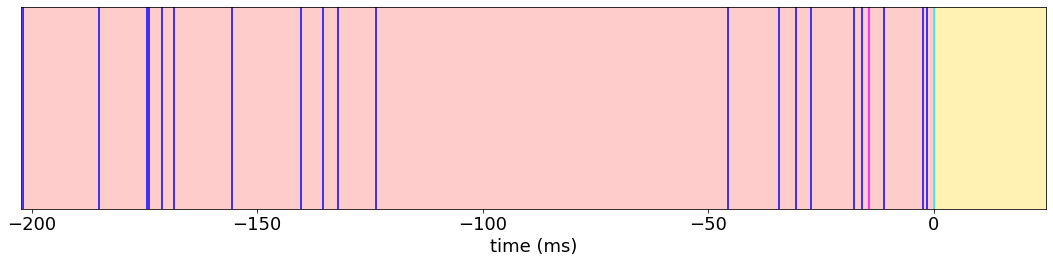

In [8]:
# sampled reference simulation figure zoom
# sampled reference simulation figure

# shift axis so that pivot stimulus is t0
pivot_stimulus = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind]
stimuli = [st - pivot_stimulus for st in stim_times if st < (1/40)*n_frames][0:pivot_ind]
sampled_spike = [st - pivot_stimulus for st in spike_times if st < (1/40)*n_frames][spike_ind]

start_time = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind - 20] - .3 - pivot_stimulus
end_time = [st for st in stim_times if st < (1/40)*n_frames][pivot_ind] + 25 - pivot_stimulus

plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1,1, figsize=(15,4), gridspec_kw={'height_ratios': [1]}, 
                         tight_layout = True, sharex = True)

# sampled spike
axes.vlines(sampled_spike, 0, 100, color='magenta')

# stimuli
axes.vlines(stimuli, 0, 100, color='blue')
axes.set_yticks([])
axes.set_ylim(0,1)


# pivot stimulus
axes.vlines(0, 0, 100, color='cyan')

# post spike windows
start = [st - pivot_stimulus for st in stim_times if st < (1/40)*n_frames][pivot_ind]
length = 25
axes.add_patch(plt.Rectangle((start,0), length, 100, color = 'gold', alpha = 0.3))

# preceding stimuli windows
start = [st - pivot_stimulus for st in stim_times if st < (1/40)*n_frames][pivot_ind - 20]
length = [st - pivot_stimulus for st in stim_times if st < (1/40)*n_frames][pivot_ind] - start
axes.add_patch(plt.Rectangle((start,0), length, 100, color = 'red', alpha = 0.2))

axes.set_xlim(start_time, end_time)

plt.xlabel('time (ms)')
plt.show()

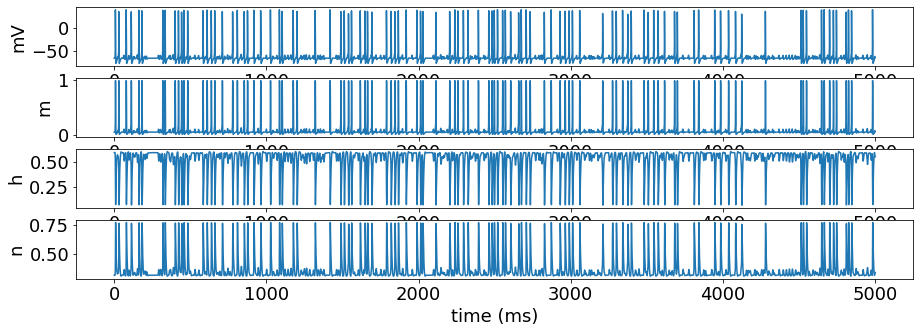

In [9]:
# histories
fig, axes = plt.subplots(4,1, figsize = (15,5))

axes[0].plot(np.arange(0, (1/40)*sim_df.shape[1], (1/40)), sim_df[1,:], )
axes[0].set_ylabel('mV')
axes[1].plot(np.arange(0, (1/40)*sim_df.shape[1], (1/40)), sim_df[2,:], )
axes[1].set_ylabel('m')
axes[2].plot(np.arange(0, (1/40)*sim_df.shape[1], (1/40)), sim_df[3,:], )
axes[2].set_ylabel('h')
axes[3].plot(np.arange(0, (1/40)*sim_df.shape[1], (1/40)), sim_df[4,:], )
axes[3].set_ylabel('n')
axes[3].set_xlabel('time (ms)')

plt.show()

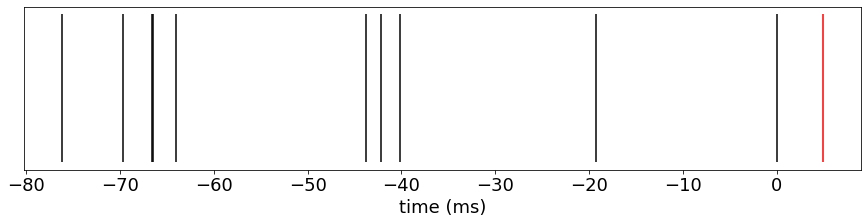

In [10]:
# set up preceding stim times for event horizon experiment (based on output spike)

num_history_stims = 10 # this is the number of stims to include in the experiment's history
pivot_ind = 20 # which output spike to use as pivot

# choose output spike as pivot
pivot = spike_times[pivot_ind]

# isolate the stimuli preceding the pivot spike
preceding_stims = [st for st in stim_times if st < pivot]
preceding_stims = preceding_stims[-num_history_stims:]

# set the last stimuli before the pivot spike as t0
pivot = pivot - preceding_stims[-1]
preceding_stims = [st - preceding_stims[-1] for st in preceding_stims]

# round stimuli and pivot to the nearest 1/40th ms
preceding_stims = [(math.floor(ps * 40))/40 for ps in preceding_stims]
pivot = (math.floor(pivot * 40))/40

# view the preceding stimuli
plt.figure(figsize = (15, 3))
plt.vlines(preceding_stims, 0, 1, color = 'black')
plt.vlines(pivot, 0, 1, color = 'red')
plt.xlabel('time (ms)')
plt.yticks([])
plt.show()